In [1]:
include("../ToolBox/ToolBox.jl")
using .ToolBox
using .UnitTest
using .Geometry
using .Load
using .Misc
using Plots
using JSON

proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


#### Hardcode gamma state vectors

In [26]:
m_state_vector_gamma, s_state_vector_gamma, gamma_time = UnitTest.gamma_state_vectors();

#### Load in gamma LUT results from Matlab

In [27]:
json_path = "/Users/eyu/Google Drive/DTU/10_semester/Persistent_scaterer/phase bug investigation/forEigil20200407/diagonal.json"
gamma_lut_dictionary = Dict()
open(json_path, "r") do f
    global gamma_lut_dictionary
    dicttxt = read(f)  # file information to string
    #print(dicttxt)
    gamma_lut_dictionary = JSON.parse(String(dicttxt))  # parse and transform data
end;
indices_sample = gamma_lut_dictionary[1]["values"]
indices_line = gamma_lut_dictionary[2]["values"]
gamma_lats = gamma_lut_dictionary[3]["values"]
gamma_lons = gamma_lut_dictionary[4]["values"]
gamma_azimuth_time = gamma_lut_dictionary[5]["values"]
gamma_slant_range = gamma_lut_dictionary[6]["values"];

In [28]:
# gamma state vector times
gamma_time = [20342, 20352, 20362, 20372, 20382, 20392, 20402, 20412, 20422, 20432, 20442, 20452, 20462, 20472, 20482];

#### Load gamma DEM

In [29]:
# Should be function, but won't work inside module for some reason.
using JSON

path_to_gamma_json = "/Users/eyu/Google Drive/DTU/10_semester/Persistent_scaterer/phase bug investigation/forEigil20200407/srdem_subset.json"
srdem_subset = Dict()
open(path_to_gamma_json, "r") do f
    global srdem_subset
    dicttxt = read(f)  # file information to string
    srdem_subset = JSON.parse(String(dicttxt))  # parse and transform data
end
gamma_dem = Array{Float64}(undef, size(srdem_subset)..., size(srdem_subset[1])...)

for i in 1:length(srdem_subset)
    gamma_dem[i, :] = transpose(srdem_subset[i])
end

#### Load meta data

In [30]:
## LOADING
master_safe_path = "/Users/eyu/local_data/data/phase_bug/BB/S1B_IW_SLC__1SDV_20170408T053951_20170408T054019_005065_008DBC_AEEF.SAFE"
m_data_path, m_meta_path, m_calibration_path = Load.slc_paths(master_safe_path, "VV", 3);
m_meta = Load.slc_meta(m_meta_path);
m_pod = Load.precise_orbit(Load.pod_path(m_meta["t_0"], m_meta["mission_id"],
                        "/Users/eyu/local_data/data/phase_bug/POD"), m_meta["t_0"])
m_start_time, m_stop_time = UnitTest.meta_start_datetime(m_meta_path);

#### Create dictionary with relevant meta data with the correct fields

In [31]:
c = 299792458
gamma_meta = Dict()
gamma_meta["t_start"] = 20394.149330 - UnitTest.seconds_since_midnight(m_meta["t_0"])
gamma_meta["t_stop"] = 20402.797055 - UnitTest.seconds_since_midnight(m_meta["t_0"])
gamma_meta["right_looking"] = true
gamma_meta["incidence_angle_mid"] = 43.5926
gamma_meta["range_sampling_rate"] = 6.4345241e+07
gamma_meta["azimuth_frequency"] = 486.4863103
gamma_meta["slant_range_time"] = 902747.0461 * 2 / c;

#### Define master view, and compute latitude and longitude

In [32]:
# input
master_view = [1:size(gamma_dem)[1], 1:size(gamma_dem)[2]]

2-element Array{UnitRange{Int64},1}:
 1:4208
 1:1500

In [33]:
## FIRST PART OF LUT, INTERPOLATE HEIGHTS
line = collect(master_view[1])
sample = collect(master_view[2])

# Get master line and sample
master_line, master_sample = Misc.flatten(line, sample)

line_sample = hcat(master_line, master_sample)
heights = vec(gamma_dem)
state_vectors = m_state_vector_gamma # m_pod[1] # state_vector_gamma
time_state_vectors = gamma_time .- UnitTest.seconds_since_midnight(m_meta["t_0"]); # wrt ref time

lat_lon = Geometry.to_lat_lon(line_sample, heights, state_vectors, time_state_vectors, gamma_meta; c = 299792458);

BoundsError: BoundsError: attempt to access 15-element Array{Float64,1} at index [[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]]

#### Compute Line Sample

In [10]:
## LOADING
slave_safe_path = "/Users/eyu/local_data/data/phase_bug/BB/S1B_IW_SLC__1SDV_20170420T053952_20170420T054019_005240_0092C6_3820.SAFE"
s_data_path, s_meta_path, s_calibration_path = Load.slc_paths(slave_safe_path, "VV", 3);
s_meta = Load.slc_meta(s_meta_path);

s_start_time, s_stop_time = UnitTest.meta_start_datetime(s_meta_path)

s_state_vectors = s_state_vector_gamma 
s_time_state_vectors = time_state_vectors # gamma_time .- UnitTest.seconds_since_midnight(m_meta["t_0"]); # m_pod[2]

s_gamma_meta = Dict()
s_gamma_meta["t_0"] = s_meta["t_0"]
s_gamma_meta["t_start"] = 20394.763347 - UnitTest.seconds_since_midnight(s_meta["t_0"])
s_gamma_meta["t_stop"] = 20403.411072 - UnitTest.seconds_since_midnight(s_meta["t_0"])
s_gamma_meta["right_looking"] = true
s_gamma_meta["incidence_angle_mid"] = 43.5925
s_gamma_meta["range_sampling_rate"] = 6.4345241e+07
s_gamma_meta["azimuth_frequency"] = 486.4863103
s_gamma_meta["slant_range_time"] = 902747.0461 * 2 / c;

In [11]:
line_sample = to_line_sample(hcat(lat_lon[:,1], lat_lon[:,2]), heights, s_state_vectors, s_time_state_vectors, s_gamma_meta);

UndefVarError: UndefVarError: lat_lon not defined

In [12]:
gamma_azimuth_time = gamma_azimuth_time .- UnitTest.seconds_since_midnight(s_meta["t_0"]);  # reference to rebel t0

In [13]:
line_grid = reshape(line_sample[:, 1], (length(line), length(sample)))
sample_grid = reshape(line_sample[:, 2], (length(line), length(sample)));

azimuth_time_grid = s_gamma_meta["t_start"] .+ line_grid / s_gamma_meta["azimuth_frequency"]
slant_range_grid = (s_gamma_meta["slant_range_time"] .+ sample_grid / s_gamma_meta["range_sampling_rate"]) .* c / 2;

In [14]:
azimuth_time_difference = Array{Float64}(undef, 100, 1)
slant_range_difference = Array{Float64}(undef, 100, 1)

for i in range(1, stop=100)
    azimuth_time_difference[i] = gamma_azimuth_time[i] - azimuth_time_grid[indices_line[i], indices_sample[i]]
    slant_range_difference[i] = gamma_slant_range[i] - slant_range_grid[indices_line[i], indices_sample[i]]
end

In [15]:
println("Maximum difference in time and meters")
maximum(azimuth_time_difference), maximum(slant_range_difference)

Maximum difference in time and meters


(0.0025192608967685715, 39.028268233756535)

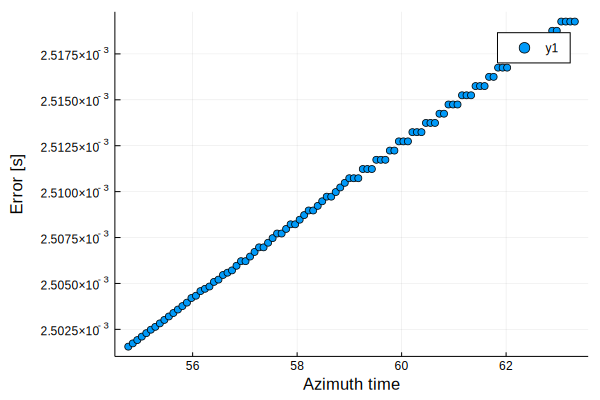

In [16]:
scatter(gamma_azimuth_time, azimuth_time_difference, xflip = false, xlabel = "Azimuth time", ylabel = "Error [s]")

In [17]:
println("Maximum azimuth error in pixels: ")
println(maximum(azimuth_time_difference) * s_gamma_meta["azimuth_frequency"])
println("Introduces the approximate error in degrees per burst of: ")
println((2 * pi * 5200 * maximum(azimuth_time_difference) * s_gamma_meta["azimuth_frequency"]) * pi/180)

Maximum azimuth error in pixels: 
1.2255859383520116
Introduces the approximate error in degrees per burst of: 
698.8827947730629


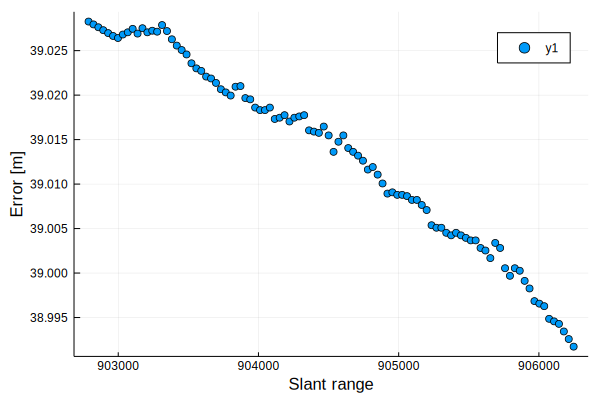

In [18]:
scatter(gamma_slant_range, slant_range_difference, xflip = false, xlabel = "Slant range", ylabel = "Error [m]")

#### Random indices

In [19]:
json_path = "/Users/eyu/Google Drive/DTU/10_semester/Persistent_scaterer/phase bug investigation/forEigil20200407/random.json"
gamma_lut_dictionary = Dict()
open(json_path, "r") do f
    global gamma_lut_dictionary
    dicttxt = read(f)  # file information to string
    #print(dicttxt)
    gamma_lut_dictionary = JSON.parse(String(dicttxt))  # parse and transform data
end;
indices_sample = gamma_lut_dictionary[1]["values"]
indices_line = gamma_lut_dictionary[2]["values"]
gamma_lats = gamma_lut_dictionary[3]["values"]
gamma_lons = gamma_lut_dictionary[4]["values"]
gamma_azimuth_time = gamma_lut_dictionary[5]["values"] .- UnitTest.seconds_since_midnight(s_meta["t_0"])  # reference to rebel t0
gamma_slant_range = gamma_lut_dictionary[6]["values"];

In [20]:
azimuth_time_difference = Array{Float64}(undef, 100, 1)
slant_range_difference = Array{Float64}(undef, 100, 1)

for i in range(1, stop=100)
    azimuth_time_difference[i] = gamma_azimuth_time[i] - azimuth_time_grid[indices_line[i], indices_sample[i]]
    slant_range_difference[i] = gamma_slant_range[i] - slant_range_grid[indices_line[i], indices_sample[i]]
end

In [21]:
println("Maximum difference in time and meters")
maximum(azimuth_time_difference), maximum(slant_range_difference)

Maximum difference in time and meters


(0.002519260894963793, 39.224341598688625)

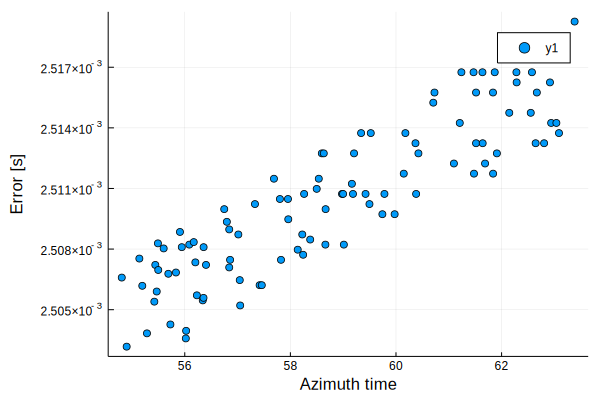

In [22]:
scatter(sort(gamma_azimuth_time), azimuth_time_difference[sortperm(gamma_azimuth_time)], xflip = false, xlabel = "Azimuth time", ylabel = "Error [s]")

In [23]:
println("Maximum azimuth error in pixels: ")
println(maximum(azimuth_time_difference) * s_gamma_meta["azimuth_frequency"])
println("Introduces the approximate error in degrees per burst of: ")
println((2 * pi * 5200 * maximum(azimuth_time_difference) * s_gamma_meta["azimuth_frequency"]) * pi/180)

Maximum azimuth error in pixels: 
1.2255859374740115
Introduces the approximate error in degrees per burst of: 
698.8827942723889


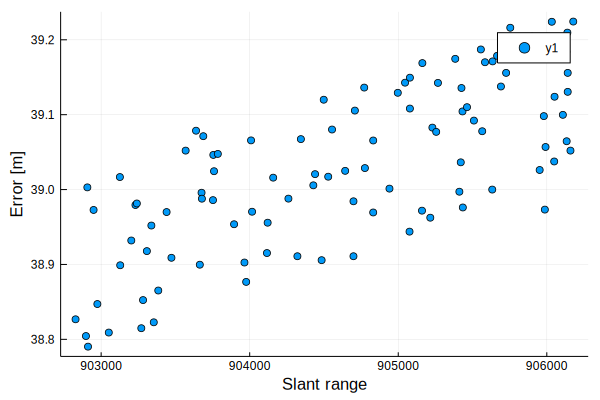

In [24]:
scatter(sort(gamma_slant_range), slant_range_difference[sortperm(gamma_slant_range)], xflip = false, xlabel = "Slant range", ylabel = "Error [m]")